In [1]:
###### DATA HANDLER ######
import numpy as np
import pandas as pd
import joblib

# from skl2onnx import convert_sklearn
# from skl2onnx.common.data_types import FloatTensorType, StringTensorType
# import onnx

###### PATH HANDLER ######
from pathlib import Path

###### VISUALISATION ######
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.subplots import make_subplots
from matplotlib.container import BarContainer

###### UTILS/TOOLS #####
import ipywidgets as widgets
from ipywidgets import interact
from ua_parser import parse

###### MACHINE LEARNING #####
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import set_config
# set_config(enable_metadata_routing=True)

from xgboost import XGBClassifier
from prince import FAMD, MCA
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from utils.data_processing import transform_ipinfo, transform_datetime, transform_proxyinfo, transform_packetinfo, df_ua_parser

In [2]:
data_path = Path("data")
raw_data = pd.read_csv(data_path.joinpath("cybersecurity_attacks.csv"))
df = raw_data.copy()
ip_columns = ["Int Source IP", "Int Destination IP", "Int Proxy Information", "Global Source IP", "Global Destination IP", "Global Proxy Information"]
ip_features = transform_ipinfo(raw_data[["Source IP Address", "Destination IP Address","Proxy Information"]])

# Exploratory Data Analysis

## Dataset Presentation

In [3]:
df.shape

(40000, 25)

The dataset provided is composed of 40 000 observations and there are 29 features that describe/give information about each one

In [4]:
df.head(5)

Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ... Action Taken  \
0  Qui natus odio asperiores nam. Optio nobis ius...  ...       Logged   
1  Aperiam quos modi officiis veritatis rem. Omni...  ...      Blocked   
2  Perferendis sapiente vitae soluta. Hic delectu...  ...      Ignored   
3  Totam maxime beatae expedita explicabo porro l...  ...      Blocked   
4  Odit nesciunt dolorem nisi iste iusto. Animi v...  ...      Blocked   

   Severity Level User Information  \
0             Low    Reyansh Dugal   
1             Low       Sumer Rana   
2             Low     Himmat Karpe   
3          Medium       Fateh Kibe   
4             Low     Dhanush Chad   

                                  Device Information Network Segment  \
0  Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...       Segment A   
1  Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...       Segment B   
2  Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...       Segment C   
3  Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...       Segment B   
4  Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...       Segment C   

    Geo-location Data Proxy Information Firewall Logs IDS/IPS Alerts  \
0  Jamshedpur, Sikkim      150.9.97.135      Log Data            NaN   
1  Bilaspur, Nagaland               NaN      Log Data            NaN   
2   Bokaro, Rajasthan    114.133.48.179      Log Data     Alert Data   
3  Jaunpur, Rajasthan               NaN           NaN     Alert Data   
4  Anantapur, Tripura     149.6.110.119           NaN     Alert Data   

  Log Source  
0     Server  
1   Firewall  
2   Firewall  
3   Firewall  
4   Firewall  

[5 rows x 25 columns]

In [5]:
df.dtypes.groupby(df.dtypes.astype(str)).size().sort_values(ascending=False)

str        21
int64       3
float64     1
dtype: int64

Of the 25 features we have: <br>
<ol><li>
20 features are of type "string". They are called categorical features as the value they can take can be grouped into categories.
</li>
<li>
4 features are of type "number" (either integer of float)
</li>
<li>
1 feature is related to the date and time of the cyber-attacks.  
</li>
</ol>

In [6]:
df.describe()

Source Port  Destination Port  Packet Length  Anomaly Scores
count  40000.000000      40000.000000   40000.000000    40000.000000
mean   32970.356450      33150.868650     781.452725       50.113473
std    18560.425604      18574.668842     416.044192       28.853598
min     1027.000000       1024.000000      64.000000        0.000000
25%    16850.750000      17094.750000     420.000000       25.150000
50%    32856.000000      33004.500000     782.000000       50.345000
75%    48928.250000      49287.000000    1143.000000       75.030000
max    65530.000000      65535.000000    1500.000000      100.000000

A quick look at the distribution of the numerical features using the function describe shows that the features are well-distributed. <br>
In fact for each features the mean and median are close to max divided by 2 and the interquartiles are close to the 25 and 75% of the maximum value respectively

In [7]:
temp_data = df.isna().sum().sort_values(ascending=False).to_frame("Missing Values")
temp_data["Percentage"] = (temp_data["Missing Values"] / 40000 * 100).round(2)
temp_data.head(10)

Missing Values  Percentage
Alerts/Warnings                  20067       50.17
IDS/IPS Alerts                   20050       50.12
Malware Indicators               20000       50.00
Firewall Logs                    19961       49.90
Proxy Information                19851       49.63
Source IP Address                    0        0.00
Destination IP Address               0        0.00
Source Port                          0        0.00
Timestamp                            0        0.00
Traffic Type                         0        0.00

There are only 5 features with missing data. <br> 
All of them are related to the detection of the cyber-attack at some point of the process. It is expected because a cyber attack might be more or less sophisticated and might trigger some detectors. <br>
For example a DDoS attack might be easily detected by a trigger looking at the traffic whereas a malware might not trigger the IDS/IPS alerts because it is a new one and its signature has not been added to the database of existing malwares.

## Types of attack

The "Attack Type" is the column to predict. 
First, it is essential to say that cyber attacks can be completely different, we could have all of them :
- Clickjacking
- Phishing
- Identity Theft
- Credential Stuffing
- DDoS Attack
- Brute Force
- Eavesdropping
- MITM (Man-in-the-middle)
- Typosquatting
- Insider Threat
- Social Engineering
- SQL Injection
- DNS Poisoning
- Drive-by Download
- XSS (Cross-site scripting)
- IoT Exploitation
- Zero Day Exploit
- Supply Chain Attack

But fortunately, in our dataset, we'll only study three of these :

| Attack Type | Description | Main Goal | Typical Methods / Vectors |
|------------|-------------|-----------|----------------------------|
| **DDoS (Distributed Denial of Service)** | Overwhelms a system, server, or network with massive traffic from many sources, making it unavailable to legitimate users. | Disrupt availability | Traffic flooding, amplification attacks (DNS, NTP, SSDP), botnets |
| **Malware** | Malicious software designed to damage, disrupt, spy on, or gain unauthorized access to systems. | Compromise systems and data | Trojans, ransomware, spyware, worms, infected downloads |
| **Intrusion** | Unauthorized access to a system or network by exploiting vulnerabilities or weak credentials. | Gain control or steal information | Exploiting vulnerabilities, stolen credentials, misconfigurations |

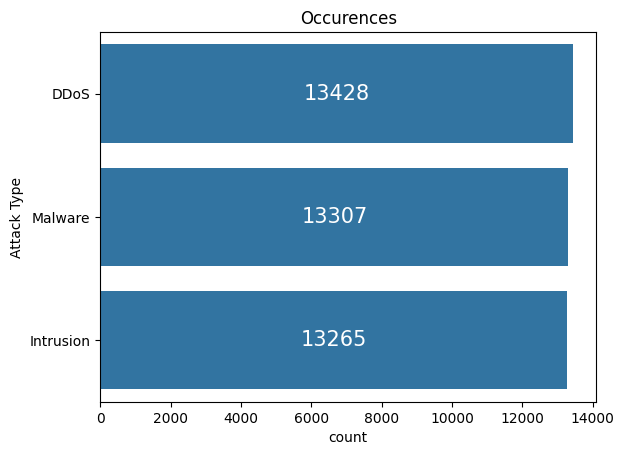

In [8]:
ax = sns.countplot(data=df, y='Attack Type', order=df['Attack Type'].value_counts().index)
container = ax.containers[0]
if isinstance(container, BarContainer):
    ax.bar_label(container, color="white", fontsize=15, label_type='center')
plt.title('Occurences')
plt.show()

## Numerical Features

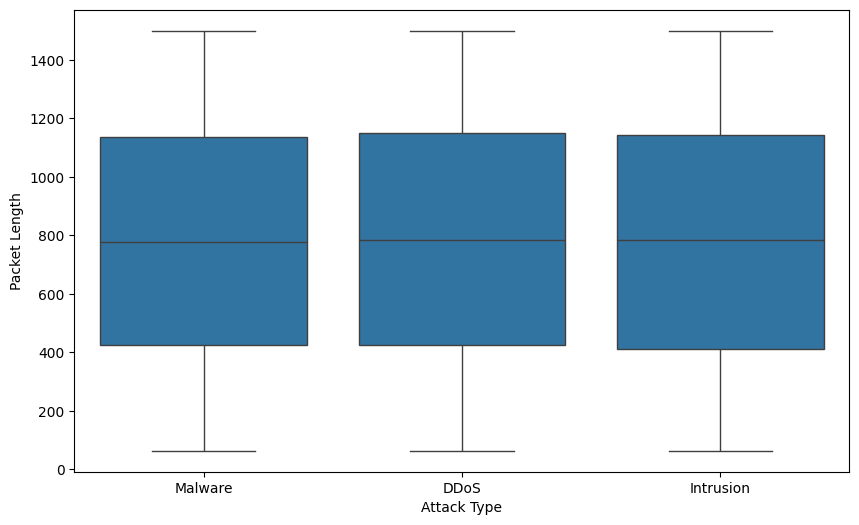

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Attack Type'],y=df['Packet Length'])
plt.show()

<Axes: ylabel='Frequency'>

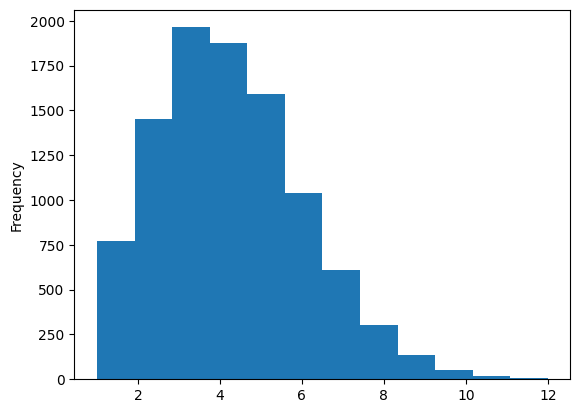

In [10]:
df['Anomaly Scores'].value_counts().plot(kind='hist', bins=12)

Packet Length
1037    47
104     45
1278    45
480     44
855     44
        ..
707     15
470     14
568     14
216     12
940      9
Name: count, Length: 1437, dtype: int64


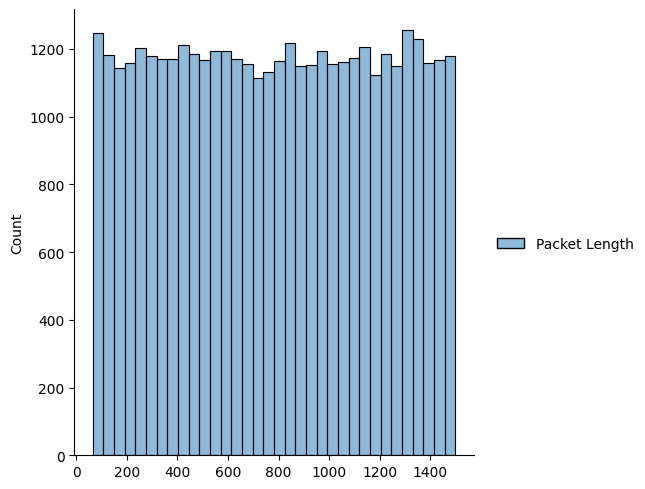

In [11]:
print(df['Packet Length'].value_counts())

sns.displot(df['Packet Length'].to_frame("Packet Length"))

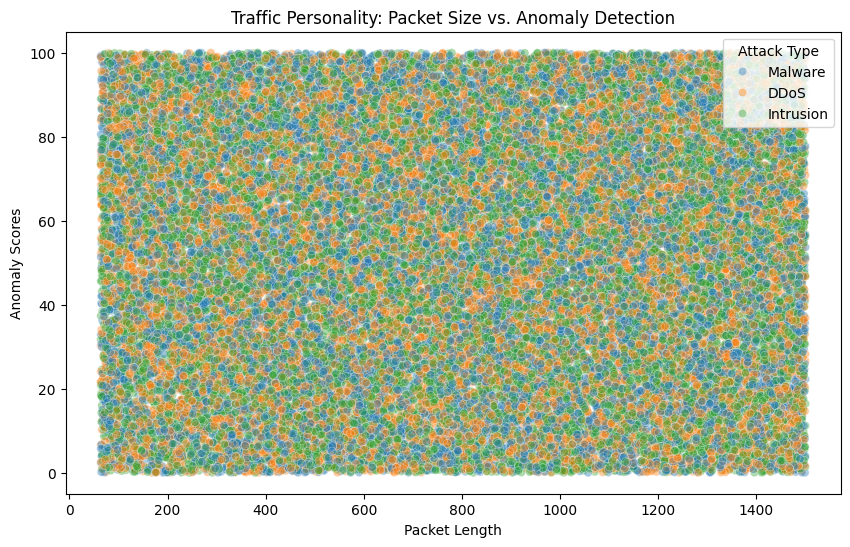

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Packet Length', y='Anomaly Scores', hue='Attack Type', alpha=0.4)
plt.title("Traffic Personality: Packet Size vs. Anomaly Detection")
plt.show()

From the graphic we cannot see clusters depending on the type of attack. The distribution appears dense. <br>
A quick look at the variance confirms it

In [13]:
num_cols_raw = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
for col in num_cols_raw:
    means = df.groupby('Attack Type')[col].mean()
    spread = (means.max() - means.min()) / df[col].std()
    print(f"{col}: normalized spread = {spread:.4f}")

df.groupby('Attack Type')[num_cols_raw].mean().round(2)

Source Port: normalized spread = 0.0023
Destination Port: normalized spread = 0.0113
Packet Length: normalized spread = 0.0175
Anomaly Scores: normalized spread = 0.0089


Source Port  Destination Port  Packet Length  Anomaly Scores
Attack Type                                                              
DDoS            32944.90          33207.36         785.35           50.24
Intrusion       32987.21          33227.41         780.92           49.98
Malware         32979.25          33017.56         778.05           50.13

The normalized spread of means across attack types is below 0.01 for all numerical features, confirming that the distributions are statistically identical between DDoS, Intrusion, and Malware, no numerical feature alone can discriminate between attack types.

In [14]:
def create_displot(data, group_labels):
    return ff.create_distplot(data, group_labels=group_labels, bin_size=25, show_hist=False, show_rug=False)

num_cols = df.select_dtypes(include="number").columns.tolist()
temp_data = df[num_cols].dropna(axis = "columns", how="any")
temp_data = (temp_data - temp_data.mean(axis=0)) / temp_data.std(axis=0)
displot = create_displot([temp_data[x] for x in num_cols], group_labels=[x for x in num_cols])
displot.show()

From the kernel density estimation, we can see the data is fairly distributed among the possible values of each numerical feature. <br> 
In fact the KDE are all close to a uniform distribution ( meaning all values would have the same probability of appearing). <br>

In [15]:
temp_data["Attack Type"] = df["Attack Type"]
num_cols = temp_data.select_dtypes(include="number").columns.tolist()
nb_cols = 4
nb_rows = int(np.ceil(len(num_cols) / nb_cols))
fig = make_subplots(rows=nb_rows, cols=nb_cols)
for i, col in enumerate(num_cols):
    row = i // nb_cols + 1
    col_pos = i % nb_cols + 1
    hist_data = [temp_data[temp_data["Attack Type"] == attack_type][col].values for attack_type in temp_data["Attack Type"].unique()]
    displot = create_displot(hist_data, group_labels=temp_data["Attack Type"].unique())
    for trace in displot.select_traces():
        fig.add_trace(trace, row=row, col=col_pos,)
        fig.update_xaxes(title_text=f"{col} Distribution", row=row, col=col_pos)

fig.update_layout(title="Kernel Density of Numerical Features by Attack Type",
                  width=1600, height=nb_rows*400+200, showlegend=False)
fig.show()

Nonetheless if we then look at it by type of attack, we can see there are small variations. 

## Date and time related features

Starting with the date, we noticed that is was considered as str value before. Therefore, we need to convert all the values of this column into dates. As we see below, the date goes from the first january 2020 to the 11 October 2023 and isn't sorted, so we'll need to sort it in order to plot. Here is what we want to plot :

In [16]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Converts text → date/time
df['hour'] = df['Timestamp'].dt.hour # Extracts the hour of the day from the timestamp col.
df['day'] = df['Timestamp'].dt.day # Gets day of month

In [17]:
pd.set_option('display.max_columns', None)
df.groupby('hour')['Attack Type'].value_counts().unstack().T

hour          0    1    2    3    4    5    6    7    8    9    10   11   12  \
Attack Type                                                                    
DDoS         604  567  559  555  574  547  541  563  570  558  540  580  517   
Intrusion    544  531  548  560  575  567  553  526  564  516  607  510  554   
Malware      557  532  546  537  574  559  539  534  530  565  544  575  517   

hour          13   14   15   16   17   18   19   20   21   22   23  
Attack Type                                                         
DDoS         580  537  586  575  548  534  524  605  565  548  551  
Intrusion    583  538  563  539  576  557  561  562  568  530  533  
Malware      574  586  571  562  547  574  580  557  549  525  573

In [18]:
pd.reset_option('display.max_columns')
day_attacks = df[(df['hour'] >= 8) & (df['hour'] < 20)].groupby(['Attack Type'] ).size().to_frame("day attacks") # rows between 08:00am  and 19:59pm
night_attacks = df[(df['hour'] < 8) | (df['hour'] >= 20)].groupby(['Attack Type'] ).size().to_frame("night attacks")# attacks between midnight and 7:59 AM or attacks between 8 PM and 11:59 PM selects either of them
dn_df = day_attacks.merge(night_attacks, how='outer', left_index=True, right_index=True)
dn_df["Total"] = dn_df.sum(axis=1)
dn_df = dn_df.T
dn_df["Total"] = dn_df.sum(axis=1)
dn_df

Attack Type     DDoS  Intrusion  Malware  Total
day attacks     6649       6668     6725  20042
night attacks   6779       6597     6582  19958
Total          13428      13265    13307  40000

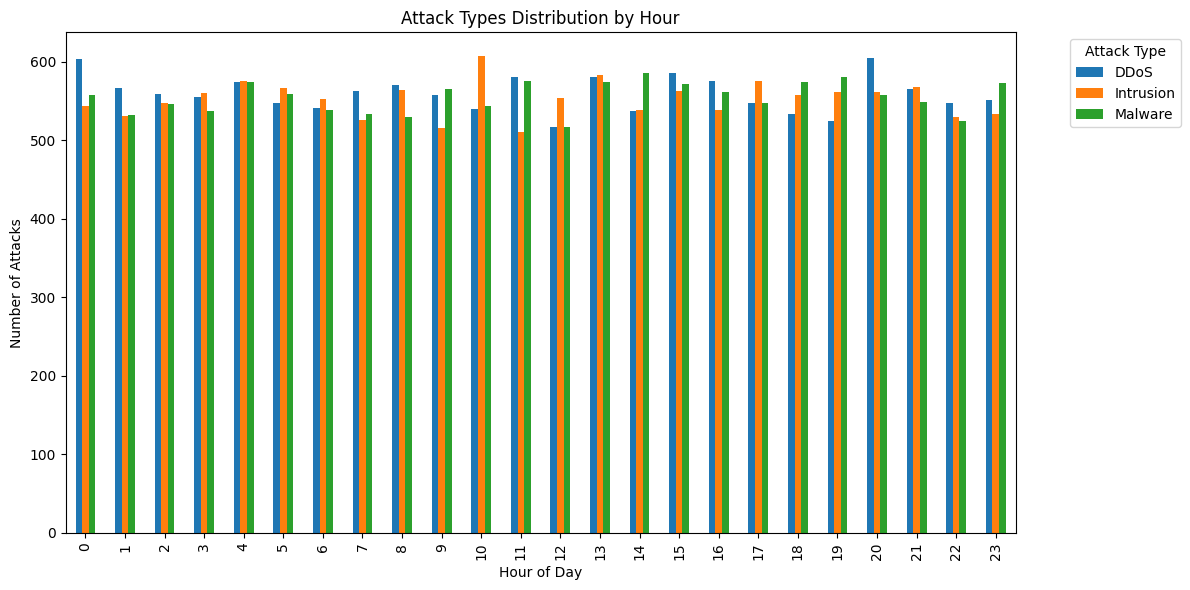

In [19]:
# Group and reshape data
hour_attack = (
    df.groupby('hour')['Attack Type']
    .value_counts()
    .unstack(fill_value=0)
)

# Plot stacked bar chart
hour_attack.plot(
    kind='bar',
    figsize=(12, 6)
)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Attacks')
plt.title('Attack Types Distribution by Hour')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Categorical features

<Axes: >

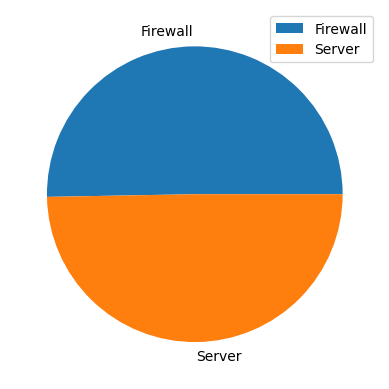

In [20]:
from pickle import TRUE

df['Log Source'].value_counts().plot(kind='pie', legend=TRUE )

In [21]:
df['Traffic Type'].value_counts()

Traffic Type
DNS     13376
HTTP    13360
FTP     13264
Name: count, dtype: int64

In [22]:
temp_data = df[["Action Taken", "Severity Level","Attack Type"]].groupby(["Action Taken", "Attack Type", "Severity Level",]).size().reset_index(name='Count')
temp_data.T

0        1        2          3          4          5   \
Action Taken    Blocked  Blocked  Blocked    Blocked    Blocked    Blocked   
Attack Type        DDoS     DDoS     DDoS  Intrusion  Intrusion  Intrusion   
Severity Level     High      Low   Medium       High        Low     Medium   
Count              1508     1509     1516       1523       1506       1524   

                     6        7        8        9   ...       17      18  \
Action Taken    Blocked  Blocked  Blocked  Ignored  ...  Ignored  Logged   
Attack Type     Malware  Malware  Malware     DDoS  ...  Malware    DDoS   
Severity Level     High      Low   Medium     High  ...   Medium    High   
Count              1499     1466     1478     1549  ...     1482    1466   

                    19      20         21         22         23       24  \
Action Taken    Logged  Logged     Logged     Logged     Logged   Logged   
Attack Type       DDoS    DDoS  Intrusion  Intrusion  Intrusion  Malware   
Severity Level     Low  Medium       High        Low     Medium     High   
Count             1441    1529       1469       1417       1425     1457   

                     25       26  
Action Taken     Logged   Logged  
Attack Type     Malware  Malware  
Severity Level      Low   Medium  
Count              1435     1556  

[4 rows x 27 columns]

<Axes: xlabel='Action Taken', ylabel='Count'>

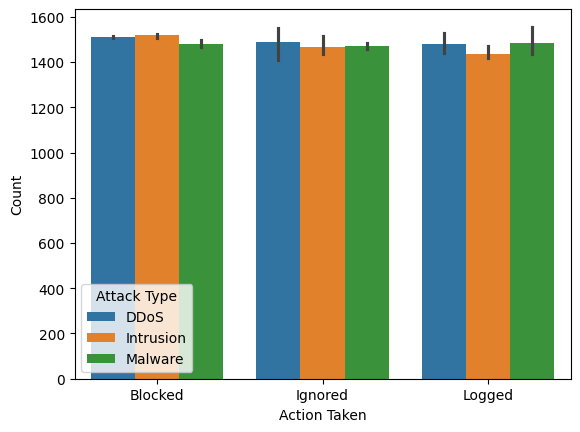

In [23]:
sns.barplot(data=temp_data, x='Action Taken', y='Count', hue='Attack Type')

In [24]:
df['Protocol'].value_counts()

Protocol
ICMP    13429
UDP     13299
TCP     13272
Name: count, dtype: int64

In [25]:
df['Log Source'].value_counts()

Log Source
Firewall    20116
Server      19884
Name: count, dtype: int64

In [26]:
df['Geo-location Data'].value_counts()

Geo-location Data
Ghaziabad, Meghalaya          16
Kalyan-Dombivli, Jharkhand    15
Ghaziabad, Tripura            14
Ghaziabad, Uttarakhand        14
Ghaziabad, Jharkhand          13
                              ..
Purnia, Uttar Pradesh          1
Cuttack, Sikkim                1
Vadodara, Meghalaya            1
Cuttack, Jharkhand             1
Nagpur, Punjab                 1
Name: count, Length: 8723, dtype: int64

Geo-location Data has 8,723 unique values across 40,000 rows, too high a cardinality for direct encoding. Since no individual location value has enough support for reliable statistics, and given the random nature of the dataset, this feature should probably be excluded from modeling.

In [27]:
# We Check if any categorical feature discriminates between attack types
cat_cols_to_check = ['Protocol', 'Traffic Type', 'Log Source', 'Action Taken',
                     'Packet Type', 'Severity Level', 'Network Segment']

print("Max attack type share deviation from 33.3% per category value:\n")
for col in cat_cols_to_check:
    temp = df.groupby(col)['Attack Type'].value_counts(normalize=True).unstack()
    max_dev = (temp - 1/3).abs().max().max()
    print(f"  {col}: {max_dev:.4f} ({max_dev*100:.1f}% max deviation)")

Max attack type share deviation from 33.3% per category value:

  Protocol: 0.0037 (0.4% max deviation)
  Traffic Type: 0.0052 (0.5% max deviation)
  Log Source: 0.0033 (0.3% max deviation)
  Action Taken: 0.0066 (0.7% max deviation)
  Packet Type: 0.0082 (0.8% max deviation)
  Severity Level: 0.0047 (0.5% max deviation)
  Network Segment: 0.0063 (0.6% max deviation)


For every categorical feature, the distribution of attack types within each category value stays within 1 and 2% of the expected 33.3%, no categorical feature shows a systematic preference for any attack type, this quantitatively confirms the absence of signal in the raw categorical features.

## Correlation Matrix

Except the data we extract from non-atomic features such as "Timestamps" or "Device Information", it does not look like there are correlations between the features and the type of attack <br>
i.e. the type of attack seems independent of whatever feature we are considering

In [31]:
corr_columns = raw_data.columns.to_list()
corr_columns.remove("Attack Type")
corr_columns.insert(0, "Attack Type")
corr_data, col_name = pd.factorize(raw_data[corr_columns[0]])
corr_data = pd.DataFrame(corr_data, columns=[corr_columns[0]])
for col in corr_columns[1:]:
    temp_data, col_name = pd.factorize(raw_data[col])
    corr_data = pd.concat([corr_data, pd.DataFrame(temp_data, columns=[col])], axis = 1)


heatmap = corr_data.corr()
fig = go.Figure(data=go.Heatmap(
    z=heatmap.values,
    x=heatmap.columns,
    y=heatmap.columns,
    text=heatmap.values,
    texttemplate="%{text:.3f}",
    textfont={"size":8,"color":"rgb(0,0,0)"},
    hoverinfo='text',
    colorscale="tealrose",
    ),
    layout=go.Layout(
        title={"text":"Correlation Heatmap",
               "x" : 0.5,
               "y":0.99,
               "font":{"size":20}},
        height=1200,
        width=1200,
        xaxis={"side":"top"}
    )
)
fig.show()

The correlation matrix above shows that some features are related to each others such as the IP addresses and the Ports. <br>
We could expect such relations between these features because they are related to the network 

In [32]:
temp_data = heatmap["Attack Type"].to_frame().T

fig = px.imshow(temp_data, text_auto=".3f", color_continuous_scale="tealrose")
fig .update_layout(
    title={"text":"Correlation Heatmap",
            "font":{"size":20}},
    xaxis={"side":"top"},
    width=1200,
    )
fig.show()

# Feature Engineering

## In Depht Analysis of some features

### Source IP Adress

The IP (Internet Protocol) Address uniquely identifies a network interface of a connected object to the internet (computer, smartphone, server...). It can be an IPv6 (version 6) coded on 128 bits, but on our case we see that they are coded on 32 bits (IPv4)

We don't have any duplicated Source IP Address. The norm RFC 1918 distinguish private and public IP address. We will analyze each IP address to see if it is public or private. According to the norm and the CIDR (Classless Inter-Domain Routing), these classes are all private IP :

| Class | Range Start | Range End | CIDR Notation | Number of Addresses |
| :--- | :--- | :--- | :--- | :--- |
| **Class A** | `10.0.0.0` | `10.255.255.255` | `10.0.0.0/8` | $2^{24} \approx 16.7 \text{ million}$ |
| **Class B** | `172.16.0.0` | `172.31.255.255` | `172.16.0.0/12` | $2^{20} \approx 1.04 \text{ million}$ |
| **Class C** | `192.168.0.0` | `192.168.255.255` | `192.168.0.0/16` | $2^{16} = 65,536$ |

In [33]:
import ipaddress as ia

In [34]:
def is_private(ip_str : str) -> bool:
    try :
        ip = ia.ip_address(ip_str)
        if ip.is_private:
                return True
        else:
            return False
    except ValueError:
        return "Invalid IP Address"

print(is_private("10.0.0.1"))
print(is_private("106.109.41.24"))

True
False


Our little function works and is ready to be applied to our column.

In [35]:
df["Source IP Address"].apply(is_private).sum()

np.int64(181)

We have 181 source IP address that are private ! We'll store them to use them later on the study of the cyber attacks.

In [36]:
source_ip_is_private = df["Source IP Address"].apply(is_private)

We could do the same thing for the Destination IP Address...

### Source Port

In technical cybersecurity analysis, the Source Port is a 16-bit integer (ranging from 0 to 65535 : 2^16-1) used by the client to uniquely identify a communication session. While the Destination Port tells you which service is being targeted (e.g., 443 for HTTPS), the Source Port provides a "behavioral fingerprint" of the attacker's operating system or tools.

To analyze ports effectively, you must distinguish between the three official categories defined by IANA (Internet Assigned Numbers Authority):

| Category | Port Range | Usage Description |
| :--- | :--- | :--- |
| **Well-Known Ports** | `0 – 1,023` | Reserved for system/administrative services (SSH, HTTP, etc.). |
| **Registered Ports** | `1,024 – 49,151` | Assigned to specific user processes or applications. |
| **Dynamic/Ephemeral Ports** | `49,152 – 65,535` | Temporary ports used by clients for outgoing connections. |

Let's write a little function to use this classification and apply it to our source port

In [37]:
def is_registered(p : int) -> bool:
    if p < 49152:
        return True
    return False

In [38]:
df["Source Port"].apply(is_registered).value_counts()

Source Port
True     30121
False     9879
Name: count, dtype: int64

Legitimate client applications (browsers, apps) almost never use a source port below 1,024. This is our case : we don't have any values under this threshold.However, we do have allmost 10 000 Source port that are not registered.

Similarly, we'll store this boolean mask for a reuse.

In [39]:
is_sourceport_registered = df["Source Port"].apply(is_registered)

We could do the same thing for the Destination Port...

### Protocol

Data is transferred from hardware to another in packets. But these packets are different according to the network protocol used. We distinguish 3 main categories of protocol : ICMP (Internet Control Message Protocol), UDP (User Datagram Protocol), TCP (Transmission Control Protocol). Each protocol handles data packets with a distinct philosophy regarding reliability, speed, and overhead. Let's have a look on this table :

| Protocol | Full Name | Connection Type | Reliability & Delivery | Typical Header Size | Key Features | Common Use Cases |
|---------|----------|----------------|------------------------|--------------------|--------------|------------------|
| TCP | Transmission Control Protocol | Connection-oriented | Guaranteed: Uses acknowledgments (ACK) and retransmission of lost segments. | 20 – 60 Bytes | 3-way handshake (SYN, SYN-ACK, ACK), sequence numbers, flow control. | HTTPS, SSH, FTP, Database queries |
| UDP | User Datagram Protocol | Connectionless | Best-effort: No guarantee of delivery, order, or error recovery. | 8 Bytes | Minimal overhead, stateless, no handshake, low latency. | VoIP, DNS, Video streaming, Online gaming |
| ICMP | Internet Control Message Protocol | Connectionless | Diagnostic: Used for error reporting and network signaling; does not carry user data. | Variable | Operates at the Network Layer (IP); uses "Type" and "Code" fields instead of ports. | Ping (Echo), Traceroute, Network congestion alerts |

We could use some analogies to remember these :
<li> TCP is like a <b> phone call </b>, where both sides establish a connection and every message is acknowledged;
<li> UDP is like <b> shouting information </b> across a room, fast but with no guarantee it’s heard or in order;
<li> ICMP is like <b> road signs and warning lights </b>, not used to carry messages, but to report problems and network status. But in which cases to use what in cyber attacks ?

| Protocol | Common Attack Scenarios | Common Ports | Why These Ports Are Used |
|--------|------------------------|-------------|--------------------------|
| **TCP** | Data exfiltration, Command & Control (C2), brute-force attacks (SSH/RDP), web attacks (SQL injection, credential stuffing) | 80 (HTTP), 443 (HTTPS), 22 (SSH), 21 (FTP), 3389 (RDP) | These ports are usually **open and trusted**, especially 80/443 which blend into normal web traffic; 443 adds **encryption**, making inspection difficult; 22 and 3389 provide **direct remote access** to systems. |
| **UDP** | DDoS amplification, UDP flood, fast network scanning | 53 (DNS), 123 (NTP), 1900 (SSDP) | UDP allows **IP spoofing** and has **no handshake**, enabling massive traffic; these services respond with **larger replies**, amplifying attack volume and overwhelming targets. |
| **ICMP** | Network reconnaissance (ping sweep), path mapping (traceroute), ICMP flood, Smurf attacks | N/A (uses Type & Code, not ports) | ICMP is often **allowed by default**, lightly monitored, and reveals **network reachability and structure**, making it useful for discovery and disruption rather than data transfer. |

### Device Information

This column contains 6 different types of information that we'll use that are all part of the "User Agent", which is  included in every HTTP header in requests to identify the client :
- The first part, like "Mozilla", is the client's webbrowser
- The second part, like "Macintosh", is the client's OS
- The third part is the layout engine, used to render the HTML, CSS, Javascript, for instance Trident (Internet Explorer), Gecko (Firefox) or Presto (Opera)
- The fourth part is the web browser specific version, like "MSIE 9.0"
- The fifth part is the architecture, the type of processor, like PPC (Power PC) or i686 (Intel 32 bits)
- The last part is the language and region, like "nl" for Netherlands

The majority of cyber attacks usually don't target the browser directly, which is the visible part (the UI), but use OS or layout engine vulnerabilities (...)
To better see each variable, we'll use the python user agent library to split our column into the most useful parts.

In [40]:
from user_agents import parse # Attention : import de 'user_agents', pas 'ua_parser'

def process_ua(ua_string):
    # On s'assure que la donnée est une chaîne de caractères
    ua = parse(str(ua_string))

    return pd.Series({
        'OS_Family': ua.os.family,
        'OS_Version': ua.os.version_string, # Désormais disponible
        'Browser': ua.browser.family,
        'Browser_Version': ua.browser.version_string,
        'Device_Type': 'Mobile' if ua.is_mobile else ('Tablet' if ua.is_tablet else 'Desktop'),
        'Is_Bot': ua.is_bot
    })
df_info = df['Device Information'].apply(process_ua)
df_info

OS_Family OS_Version        Browser Browser_Version Device_Type  Is_Bot
0       Windows          8             IE             9.0     Desktop   False
1       Windows      Vista             IE             8.0     Desktop   False
2       Windows          8             IE             9.0     Desktop   False
3      Mac OS X    10.11.5        Firefox            11.0     Desktop   False
4       Windows          8             IE             5.0     Desktop   False
...         ...        ...            ...             ...         ...     ...
39995       iOS     14.2.1    Firefox iOS            17.7      Tablet   False
39996   Windows         ME         Safari             4.1     Desktop   False
39997   Windows         NT         Safari           4.0.3     Desktop   False
39998     Linux                    Chrome        15.0.852     Desktop   False
39999       iOS        3.0  Mobile Safari           4.0.5      Mobile   False

[40000 rows x 6 columns]

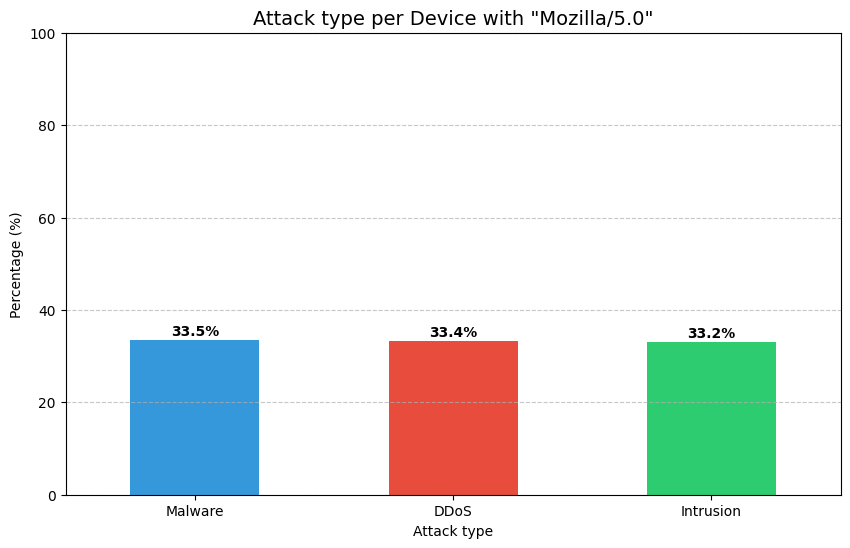

In [ ]:
df['Device_Simple'] = df['Device Information'].str.split('(').str[0].str.strip()

df_mozilla = df[df['Device_Simple'] == 'Mozilla/5.0']

mozilla_attack_ratios = df_mozilla['Attack Type'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
mozilla_attack_ratios.plot(kind='bar', color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f'])

plt.title('Attack type per Device with "Mozilla/5.0"', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Attack type')
plt.xticks(rotation=0)

for i, v in enumerate(mozilla_attack_ratios):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Attacks are fairly distributed if we take a look at a specific version of mozilla.

In [ ]:
df_opera = df[df['Device Information'].str.contains('Opera|OPR', case=False, na=False)].copy()
df_opera['Filtered'] = df_opera['Device Information'].str.extract(r'((?:Opera|OPR)/[\d\.]+)')
available_versions = sorted(df_opera['Filtered'].dropna().unique())

In [ ]:
@interact(version=available_versions)
def afficher_stats_opera(version):
    data_version = df_opera[df_opera['Filtered'] == version]

    if data_version.empty:
        print("No Data for this version")
        return

    ratios = data_version['Attack Type'].value_counts(normalize=True) * 100

    plt.figure(figsize=(10, 5))
    colors = sns.color_palette('magma', len(ratios))

    ratios.plot(kind='bar', color=colors)

    plt.title(f'Attack type per Device wit {version}', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Attack type')
    plt.ylim(0, 100)
    plt.xticks(rotation=0)

    for i, v in enumerate(ratios):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

    print(f"Count of attacks for this version : {len(data_version)}")

interactive(children=(Dropdown(description='version', options=('Opera/8.10.', 'Opera/8.11.', 'Opera/8.12.', 'O…

But it is not the case if we look at some version of opera for example

In [ ]:


def clean_ua_name(ua_string):
    try:
        ua = parse(str(ua_string))
        ua_browser = getattr(ua.user_agent,"family",None) or "Unknown"
        ua_os = getattr(ua.os,"family",None) or "Unknown"
        return f"{ua_browser} ({ua_os})"
    except Exception:
        return "Unknown"

df["Browser Name"] = df["Device Information"].apply(clean_ua_name)

fig = px.histogram(
    df,
    x="Browser Name",
    color="Attack Type",
    barmode="group",
    title="Browser Name Distribution",
    width=1200,
    height=600
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

We can see some browser have around a 1% difference between the attack type categories.

In [ ]:


def get_ua_details(ua_string):
    ua = parse(str(ua_string))
    return {
        "Browser Name": getattr(ua.user_agent,"family",None) or "Unknown",
        "Browser Version": getattr(ua.user_agent,"major",None) or "Unknown"
    }

device_info = df["Device Information"].apply(lambda x: pd.Series(get_ua_details(x)))

chrome_version_data = pd.read_csv("data/chrome_versions.csv", sep=';')
chrome_version_data["release_date"] = pd.to_datetime(chrome_version_data["release_date"], format = "%d/%m/%Y")
chrome_version_data["version"] = chrome_version_data["version"].str.split(".",n = 1).str[0]

temp_data = device_info.reset_index(names=["Original Index"])
temp_data = temp_data[temp_data["Browser Name"] == "Chrome"].copy()

temp_data = temp_data.merge(chrome_version_data, left_on="Browser Version", right_on="version", how="left")
temp_data = temp_data.merge(df["Attack Type"], left_on="Original Index", right_index=True)

version_order = sorted(temp_data["version"].dropna().unique(), key=lambda x: int(x))

fig = px.histogram(
    temp_data,
    x="version",
    title="Chrome Version Distribution",
    color="Attack Type",
    barmode="group",
    width=1400,
    height=500
)

fig.update_xaxes(type="category", categoryorder="array", categoryarray=version_order)
fig.show()

The spread is even bigger if we look at the version of browser

In [ ]:
# Summary of attack type distribution by browser family
browser_summary = df.groupby('Browser Name')['Attack Type'].value_counts(normalize=True).unstack()
print("Attack type distribution by browser (showing deviation from 33.3%):")
print((browser_summary - 1/3).round(3))

Attack type distribution by browser (showing deviation from 33.3%):
Attack Type                DDoS  Intrusion  Malware
Browser Name                                       
Chrome (Android)          0.001     -0.012    0.011
Chrome (Linux)           -0.011      0.008    0.003
Chrome (Mac OS X)        -0.010     -0.006    0.017
Chrome (Windows)          0.006     -0.013    0.007
Chrome Mobile iOS (iOS)   0.000      0.016   -0.017
Firefox (Linux)           0.008      0.012   -0.020
Firefox (Mac OS X)       -0.006      0.021   -0.016
Firefox (Windows)         0.004     -0.003   -0.001
Firefox Mobile (Android)  0.009      0.006   -0.014
Firefox iOS (iOS)         0.012     -0.005   -0.007
IE (Windows)              0.006     -0.010    0.004
Mobile Safari (iOS)       0.000      0.015   -0.015
Opera (Linux)             0.020     -0.013   -0.007
Opera (Windows)           0.002      0.010   -0.012
Safari (Mac OS X)        -0.007     -0.016    0.023
Safari (Windows)         -0.016     -0.003    0.

Across all browser families, the attack type distribution remains at approximately 33%/33%/33%. Looking at a more precise information like the version of the browser the distriution starts to be unenven.

### Time Line Analysis

The goal is to plot each time series (year, month, day, hour, minute, second) in a line plot to see the distribution. This is our plot function. 

In [41]:
def time_line_analysis(df, column_name, ax=None, label=None):
    data_counts = df[column_name].value_counts().sort_index()

    # si aucun axe passé, on en crée un (cas usage solo)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(data_counts.index, data_counts.values, marker='o', linestyle='-', label=label)
    ax.set_title(f"Line Chart for {column_name}")
    ax.set_ylabel("Frequency")
    ax.set_xlabel(column_name)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    return ax

We need to convert the Timestamp column (str type) to a Datetime type here below. 

In [42]:
df["Timestamp"]=pd.to_datetime(df["Timestamp"])

In [43]:
df["Year"]=df["Timestamp"].dt.year
df["Month"]=df["Timestamp"].dt.month
df["Day"]=df["Timestamp"].dt.day
df["Hour"]=df["Timestamp"].dt.hour
df["Minute"]=df["Timestamp"].dt.minute
df["Second"]=df["Timestamp"].dt.second


In [44]:
cols_to_cycle = ["Year", "Month", "Day", "Hour", "Minute", "Second"]

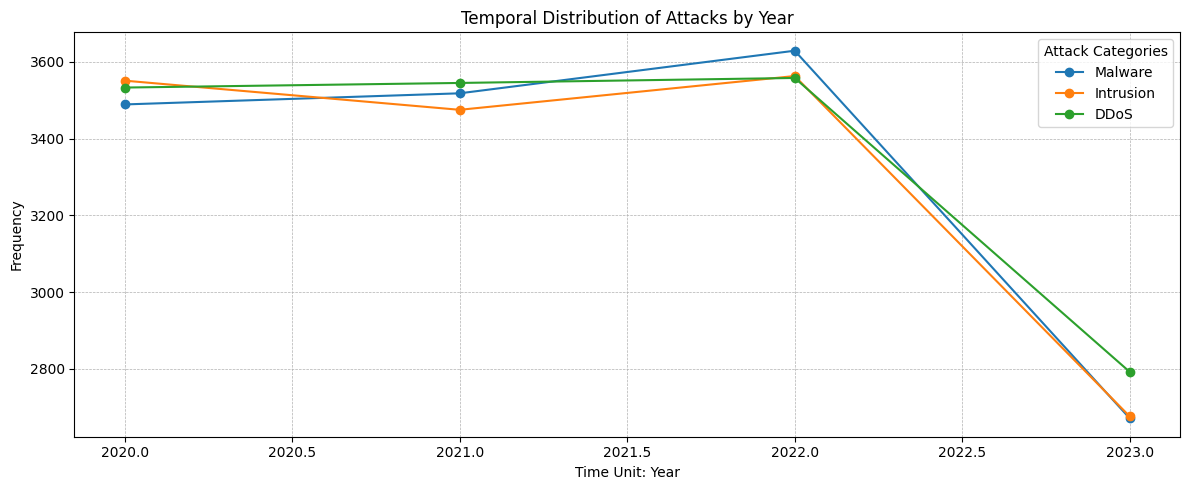

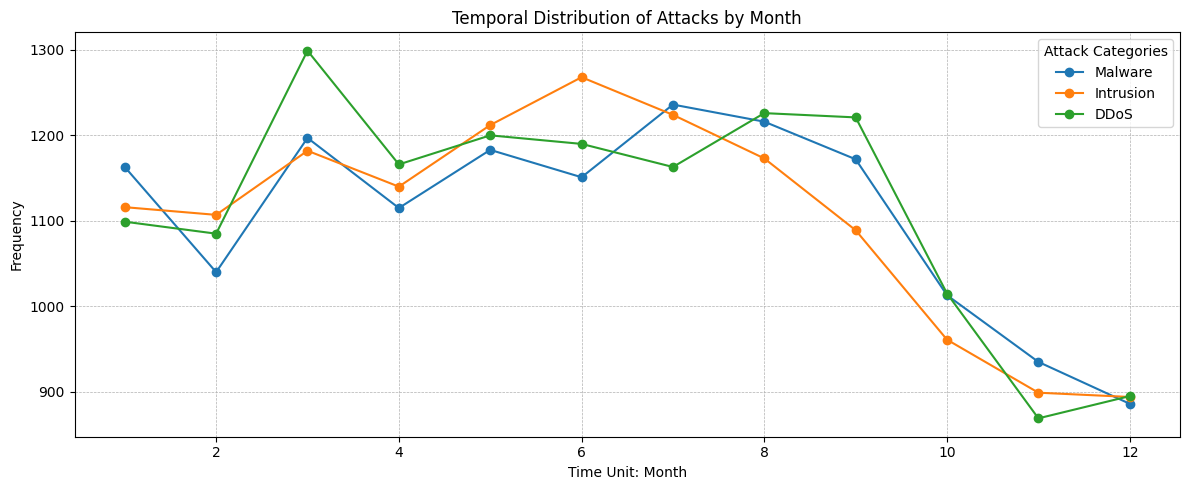

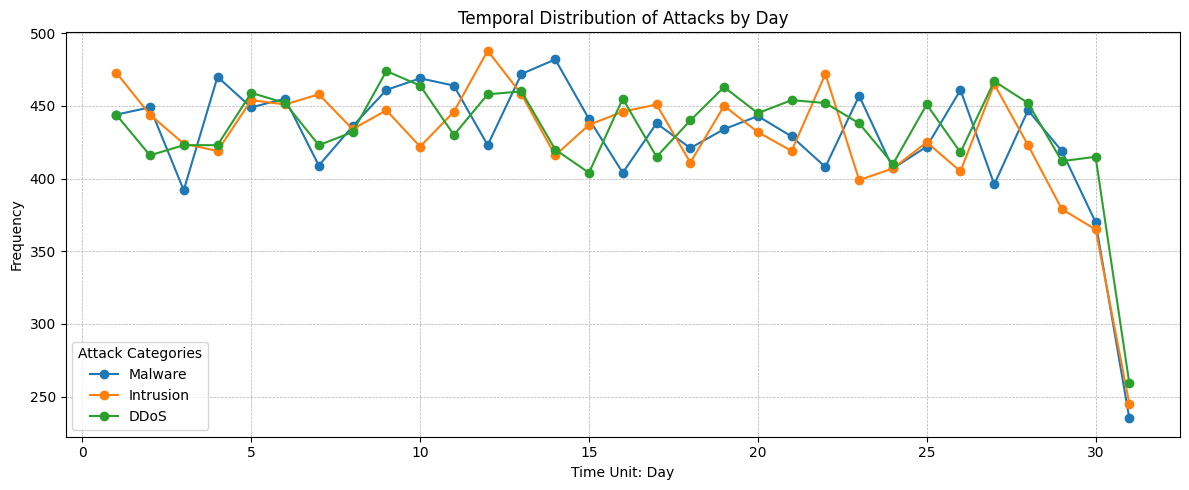

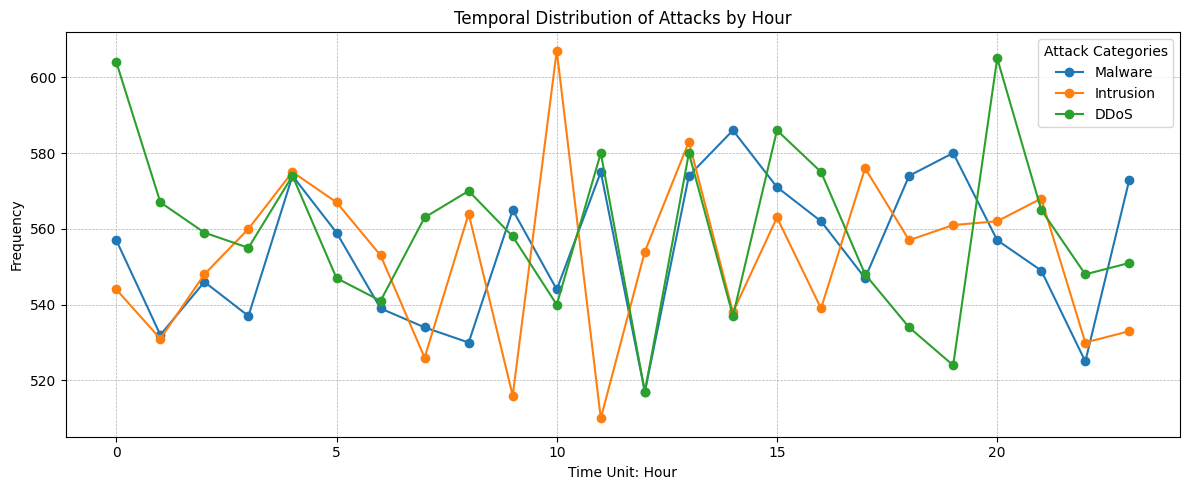

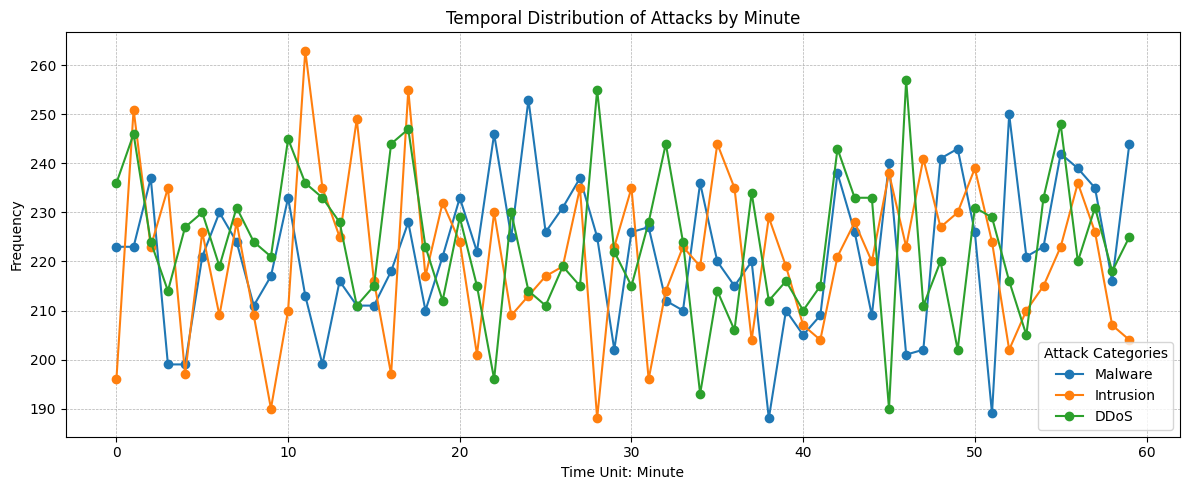

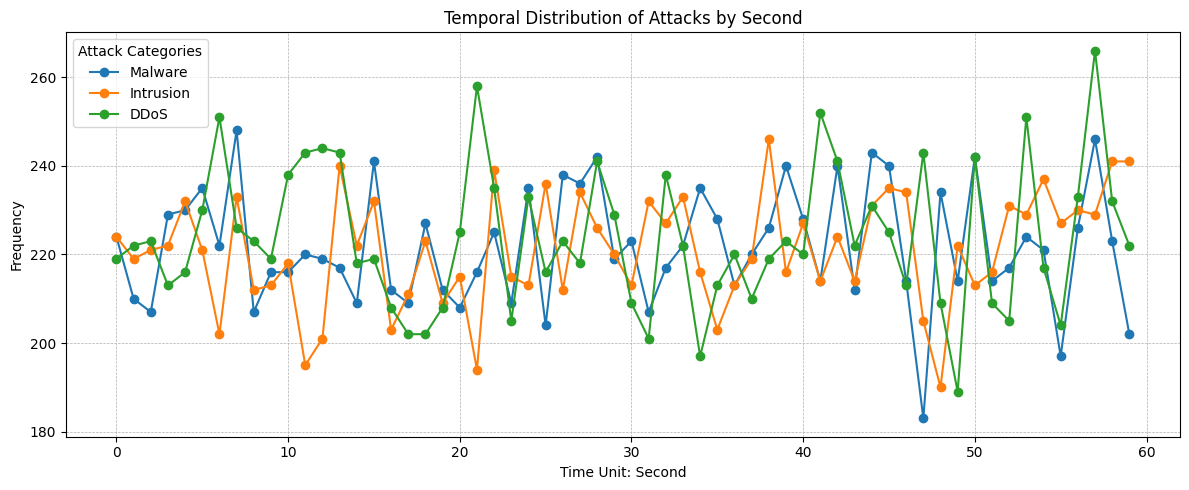

In [45]:
# Define the categories for segmentation
attack_types = ["Malware", "Intrusion", "DDoS"]

# Primary loop iterating through temporal granularities
for col in cols_to_cycle:
    # Initialize a discrete figure and axes for each temporal unit (Year, Month, etc.)
    fig, ax = plt.subplots(figsize=(12, 5))

    # Nested loop to superimpose attack types onto a single coordinate system
    for attack in attack_types:
        # Segment the DataFrame according to the specific attack vector
        subset = df[df["Attack Type"] == attack]

        # Invoke the analysis function using the column identifier (string)
        # We pass the 'ax' object to ensure all traces are rendered on the same subplot
        time_line_analysis(subset, col, ax=ax, label=attack)

    # Finalize the aesthetic and metadata properties of the current visualization
    ax.set_title(f"Temporal Distribution of Attacks by {col}")
    ax.set_xlabel(f"Time Unit: {col}")
    ax.legend(title="Attack Categories")

    # Optimize subplot parameters for a clean, non-overlapping layout
    plt.tight_layout()
    plt.show()

We do see little variation in time, but regarding the scale of the graph, we see that these variations are really tiny. 

## Component Analysis

A common thing to improve ML model performance is to select only the features that contain the most information.
An algorithm to do so is the Principal Component Analysis (or PCA) which consists on a linear dimensionnality reduction of the total space

In [ ]:
RANDOM_STATE = 124
X_orig = raw_data.copy().drop(columns=["Attack Type"])
X_orig = X_orig.merge(ip_features, left_index=True, right_index=True, how="left")
X_orig = X_orig.drop(columns=["Source IP Address", "Destination IP Address", "Proxy Information", "Int Proxy Information",
                              "Global Source IP Address", "Global Destination IP Address", "Global Proxy Information"])

In [47]:
cat_cols = X_orig.select_dtypes(include=["object","str"]).columns
num_cols = X_orig.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_orig.columns if col not in cat_cols and col not in num_cols]

MAX_CARDINALITY = 100

cardinality_info = {}
for col in cat_cols:
    cardinality = X_orig[col].nunique()
    cardinality_info[col] = cardinality

cardinality_df = pd.DataFrame.from_dict(cardinality_info, orient='index', columns=['Cardinality'])
cardinality_df = cardinality_df.sort_values('Cardinality', ascending=False)

print(f"Categorical features with cardinality:")
print(cardinality_df)

# Filter out high cardinality features
high_card_cols = cardinality_df[cardinality_df['Cardinality'] > MAX_CARDINALITY].index.tolist()
print(f"Removing {len(high_card_cols)} high-cardinality features (>{MAX_CARDINALITY} unique values): {high_card_cols}")

# Update cat_cols to exclude high cardinality features
cat_cols = [col for col in cat_cols if col not in high_card_cols]
cat_cols.extend(num_cols)
print(f"Remaining features: {", ".join(cat_cols)}")

# Drop high cardinality columns from train and test sets
X_lowcard = X_orig.drop(columns=high_card_cols)

Categorical features with cardinality:
                    Cardinality
Payload Data              40000
Timestamp                 39997
User Information          32389
Device Information        32104
Geo-location Data          8723
Severity Level                3
Protocol                      3
Traffic Type                  3
Action Taken                  3
Network Segment               3
Log Source                    2
Attack Signature              2
Packet Type                   2
Malware Indicators            1
Alerts/Warnings               1
Firewall Logs                 1
IDS/IPS Alerts                1
Removing 5 high-cardinality features (>100 unique values): ['Payload Data', 'Timestamp', 'User Information', 'Device Information', 'Geo-location Data']
Remaining features: Protocol, Packet Type, Traffic Type, Malware Indicators, Alerts/Warnings, Attack Signature, Action Taken, Severity Level, Network Segment, Firewall Logs, IDS/IPS Alerts, Log Source, Source Port, Destination Port, 

In [48]:
cat_cols = X_lowcard.select_dtypes(include=["object","str"]).columns
num_cols = X_lowcard.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]

numeric_transformer = Pipeline(
        steps = [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])

cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
        ])

preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_transformer, cat_cols),
            ("num", numeric_transformer, num_cols)
        ]).set_output(transform="pandas")

x_processed = preprocessor.fit_transform(X_lowcard)
cat_cols = x_processed.select_dtypes(include=["object","str"]).columns
num_cols = x_processed.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]
x_processed[cat_cols] = x_processed[cat_cols].astype("category")
x_processed[num_cols] = x_processed[num_cols].astype("float32")

famd = FAMD(n_components=x_processed.shape[1], n_iter=3, random_state=RANDOM_STATE)
famd.fit(x_processed)
famd.eigenvalues_summary.T

component                       0       1       2       3       4        5   \
eigenvalue                   1.019   1.006   1.003   0.996   0.994    0.982   
% of variance               16.98%  16.77%  16.71%  16.61%  16.56%   16.37%   
% of variance (cumulative)  16.98%  33.75%  50.46%  67.06%  83.63%  100.00%   

component                        6        7        8        9        10  \
eigenvalue                    0.000    0.000    0.000    0.000    0.000   
% of variance                 0.00%    0.00%    0.00%    0.00%    0.00%   
% of variance (cumulative)  100.00%  100.00%  100.00%  100.00%  100.00%   

component                        11       12       13       14       15  \
eigenvalue                    0.000    0.000    0.000    0.000    0.000   
% of variance                 0.00%    0.00%    0.00%    0.00%    0.00%   
% of variance (cumulative)  100.00%  100.00%  100.00%  100.00%  100.00%   

component                        16       17  
eigenvalue                    0.000    0.000  
% of variance                 0.00%    0.00%  
% of variance (cumulative)  100.00%  100.00%

According to the FAMD algorithms, our dataset can be reduced to a 5-dimension space, the rest not adding value.

In [49]:
famd.column_contributions_.style.format('{:.0%}')

If we look at the contribution of each feature, we notice that the numerical ones are the only ones that contain informations. <br>
Because it is an unexpected results, an MCA analysis is done with the categorical features only. <br>

In [50]:
cat_cols = X_lowcard.select_dtypes(include=["object","str"]).columns
X_lowcard = X_lowcard[cat_cols]

cat_cols = X_lowcard.select_dtypes(include=["object","str"]).columns
num_cols = X_lowcard.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]

numeric_transformer = Pipeline(
        steps = [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])

cat_transformer = Pipeline([
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="None")),
        ])

preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_transformer, cat_cols),
            ("num", numeric_transformer, num_cols)
        ]).set_output(transform="pandas")

x_processed = preprocessor.fit_transform(X_lowcard)
cat_cols = x_processed.select_dtypes(include=["object","str"]).columns
num_cols = x_processed.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]
x_processed[cat_cols] = x_processed[cat_cols].astype("category")
x_processed[num_cols] = x_processed[num_cols].astype("float32")

mca = MCA(n_components=x_processed.shape[1], n_iter=3, random_state=RANDOM_STATE)
mca.fit(x_processed)
mca.eigenvalues_summary.T

component                      0       1       2       3       4       5   \
eigenvalue                  0.086   0.085   0.085   0.085   0.084   0.084   
% of variance               6.07%   6.03%   6.02%   6.00%   5.96%   5.93%   
% of variance (cumulative)  6.07%  12.10%  18.12%  24.12%  30.08%  36.01%   

component                       6       7       8       9       10      11  
eigenvalue                   0.084   0.084   0.083   0.083   0.083   0.083  
% of variance                5.91%   5.90%   5.87%   5.86%   5.83%   5.82%  
% of variance (cumulative)  41.92%  47.81%  53.69%  59.55%  65.38%  71.20%

All categorical features have the same importance meaning there is not one that might be more important than the rest. <br>

In [51]:
contributions = famd.column_contributions_
contributions["total"] = contributions.sum(axis=1)
contributions = contributions.sort_values("total", ascending=False)
contributions = contributions[contributions["total"] > 0.005]
important_features = [feature.replace("cat__","").replace("num__","") for feature in contributions.index.tolist()]
print(f"Number of features contributing more than 0.5%: {len(important_features)}")
print(f"Important features: {important_features}")

Number of features contributing more than 0.5%: 6
Important features: ['Int Source IP Address', 'Int Destination IP Address', 'Destination Port', 'Source Port', 'Packet Length', 'Anomaly Scores']


# Machine Learning Model

In [35]:
y = raw_data['Attack Type']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_labels = le.classes_.tolist()
RANDOM_STATE = 124

A LabelEncoder is used to encode the attack types. It transforms the labels into values between 0 and n-1 classes (2 in our cases)

## Baseline Model

Our baseline models used all the features from the original dataset except the only change is to convert IP addresses from string to int.
We will use two types of classifier: a Random Forest Classifier and a Histogram-based Gradient Boosting Classification Tree.


In [9]:
df = raw_data.copy().drop(columns=["Attack Type","Source IP Address", "Destination IP Address"])
df = df.merge(ip_features[["Int Source IP Address","Int Destination IP Address"]], left_index=True, right_index=True, how="left")
cat_cols = [col for col in df.select_dtypes(include=["object","str"]).columns if col != "Payload Data"]
num_cols = df.select_dtypes(include="number").columns
text_feature = 'Payload Data'

_tmp = SimpleImputer(strategy="constant", fill_value="None").fit_transform(df[cat_cols])
_tmp_ohe = OneHotEncoder(handle_unknown="ignore",drop="first").fit(_tmp)
all_categories = _tmp_ohe.categories_ # make sure all categories are included in the one-hot encoding. Did this for high dimensionality features that will be dropped later anyway.

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")), # Fill missing values with "None" in the pipeline directly instedad of pre-filling the dataframe. Avoid errors and is more efficient.
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),                
        ('cat', cat_prepocessor, cat_cols), 
        ('text', TfidfVectorizer(max_features=50), text_feature)      
    ]
)

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=1))
])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, y_encoded, test_size=0.2, random_state=RANDOM_STATE)

print("Training the model... Please wait...")
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_labels))

Training the model... Please wait...

--- Pipeline Results ---
Accuracy Score: 0.3284

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.33      0.39      0.36      2661
   Intrusion       0.32      0.28      0.30      2685
     Malware       0.33      0.31      0.32      2654

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



In [54]:
joblib.dump(rf_model, data_path.joinpath("final_model.joblib"))

['data/final_model.joblib']

### Baseline Results

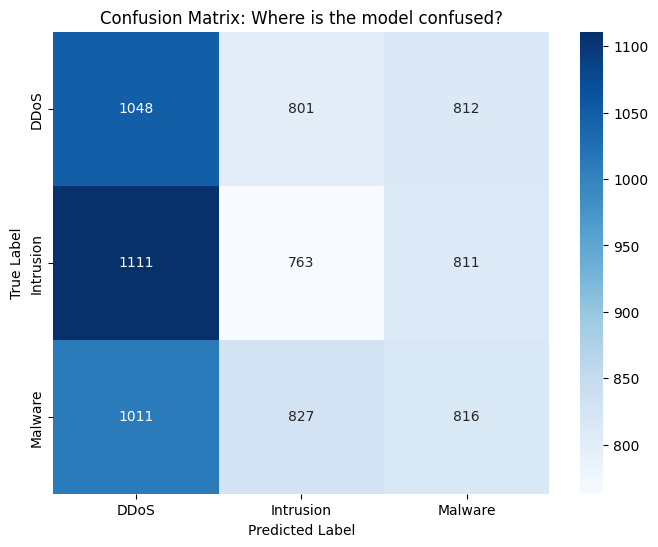

In [55]:
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Where is the model confused?')
plt.show()

The confusion matrix shows that the model tends to predict more DDoS attack whereas it should be relatively even among all the categories. <br>
On the other side the "Intrusion" category" is under predicted. <br>
From this graphic we can calcualte the data shown in the classification in the previous cell:
1. $`\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}`$ <br>
    Looking at the Intrusion type, $\frac{763}{763 + 801 + 827} =0.3191 \approx 32\%$  which is the value found in the previous cell 
2. $`\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}`$ <br>
    Looking at the DDoS type, $\frac{1048}{1048 + 801 + 812} = 0.3938 \approx 39\% $, which is the exact value found in the previous cell


Calculating feature importance (Permutation Importance)...


/home/florians/cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



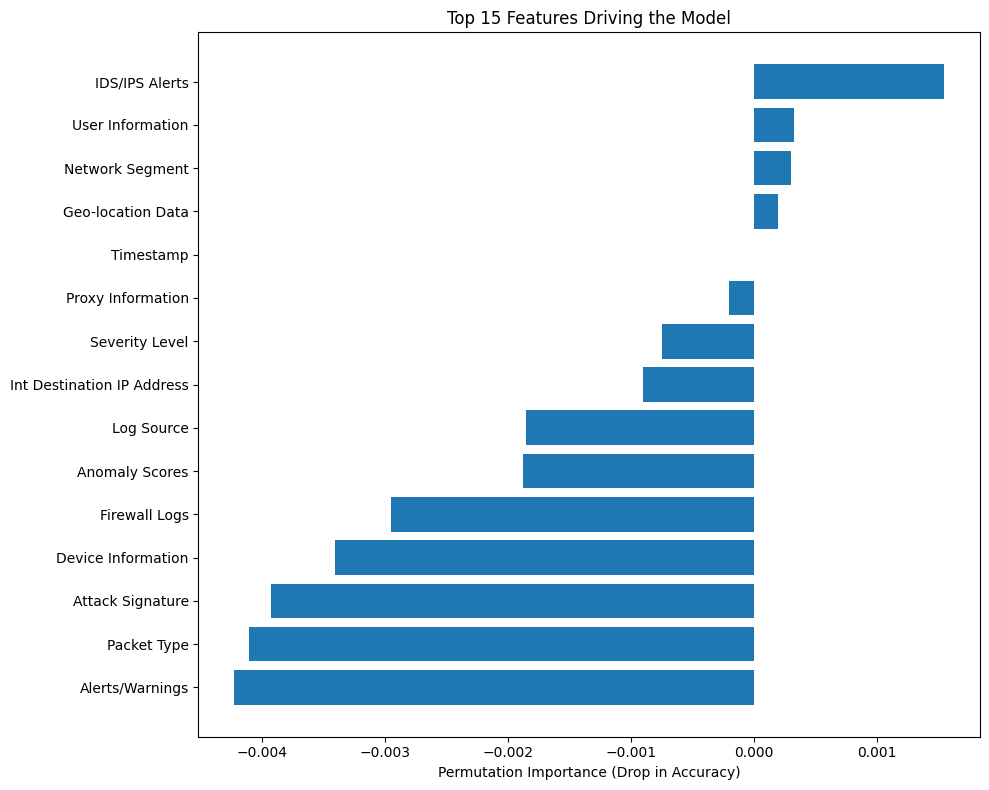

In [56]:
print("Calculating feature importance (Permutation Importance)...")
result = permutation_importance(rf_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[-15:] # Top 15 features
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Drop in Accuracy)")
plt.title("Top 15 Features Driving the Model")
plt.tight_layout()
plt.show()

Compare to the MCA analyis, the features that impact the most the accuracy of the model are not only the categorical ones. <br>
Main differences from the analysis is that high-dimensionnality features are used. <br>
Nonetheless it confirms that model does not rely on any particular feature: drop/improvement in accuracy is close to zero with a maximum change below 0.5%. <br>
It means that the type of attack is most certainly independent of the features provided <br>
 

In [57]:
scores = cross_val_score(rf_model, df, y_encoded, cv=5, verbose=2, n_jobs=6)
print(f"Average Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.3min


[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.9min


[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.2min


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  4.3min finished


Average Cross-Validation Accuracy: 0.3306 (+/- 0.0068)


Our baseline model using a RamdomForest achieve around 0.33 accuracy, which means it cannot identify patterns and determine what type of cyber attack happened based on the sole dataset without any feature engineering and research of better parameters. <br> 
The confusion matrix and classification reports indicates the model tends to over predict the DDoS category. Some investigation on that result may help to improve the model accuracy.  <br>
Cross-validation results confirm the model's robustness, with consistent performance across folds.

## Other Classifier

### Gradient Boosting Classifier

In [ ]:
def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

df = raw_data.copy().drop(columns=["Attack Type","Source IP Address", "Destination IP Address"])
df = df.merge(ip_features[["Int Source IP Address","Int Destination IP Address"]], left_index=True, right_index=True, how="left")
cat_cols = [col for col in df.select_dtypes(include=["object","str"]).columns if col != "Payload Data"]
num_cols = df.select_dtypes(include="number").columns
text_feature = 'Payload Data'

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', cat_prepocessor, cat_cols),
        ('text', TfidfVectorizer(max_features=50, stop_words='english'), text_feature)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dense', FunctionTransformer(to_dense)), # Converts text vectors for the booster
    ('classifier', HistGradientBoostingClassifier(random_state=42, max_iter=100))
])

X_train, X_test, y_train, y_test = train_test_split(df, y_encoded, test_size=0.2, random_state=42)
print("Training the Boosting Pipeline... this may take a moment.")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n--- Model Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_labels))

Training the Boosting Pipeline... this may take a moment.

--- Model Results ---
Accuracy Score: 0.3235

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.33      0.44      0.37      2636
   Intrusion       0.33      0.21      0.26      2721
     Malware       0.31      0.32      0.32      2643

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.32      8000
weighted avg       0.32      0.32      0.32      8000



## Finding Hyper-Parameters

One way to improve a model is to find better parameters of the classifier that is used.
For example for a Random Forest Classifier we can define:
1. The number of trees (n_features). The output of this classifier is the class selected by most trees. So by having more trees, there are better probabilities that a subset of the trees finds a good classification.
2. The maximum depth of each tree. At each step of the decision tree classifier, the algorithm will split the data according to a feature. Reducing the depth of the tree decreases the likelihood of overfitting i.e. developping a model specific to the train set.
3. The minimum of samples after each split. Like the maximum depth, limiting the split to a minimum of samples after decreases the likelihood of overfitting.

We use a GridSearchCV. It is a simple search over the specified parameter values for the estimator. The algorithm is exhaustive meaning all combinations are tested.

### Without High Dimensionnality Features

The first idea we had to improve the model was to not used the features with a high dimensionnality.
The decision tree algorithm split at each step according to the feature that provide the most pure split (i.e with the less missmatch between the predicted label and its true value).
In the case of high-dimensionnal feature, this kind of algorithm does not work well because there are not enough sample for each label to determine what should be predicted.
We also remove the Payload-Data because after analysing the text, we realised it was not the data from the cyber attack but rather a placeholder with no meaning

In [4]:
lowcard_df = raw_data.copy().drop(columns=["Attack Type","Source IP Address", "Destination IP Address"])
lowcard_df = lowcard_df.merge(ip_features[["Int Source IP Address","Int Destination IP Address"]], left_index=True, right_index=True, how="left")
lowcard_df = lowcard_df.drop(columns=["User Information", "Device Information", "Geo-location Data", "Payload Data","Timestamp","Proxy Information"])

In [ ]:
df = lowcard_df.copy()

num_features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores',"Int Source IP Address","Int Destination IP Address"]
cat_features = ['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators', 'Alerts/Warnings', 
                'Attack Signature', 'Action Taken', 'Severity Level', 'Network Segment', 'Log Source']

X = df[num_features + cat_features]
_tmp = SimpleImputer(strategy="constant", fill_value="None").fit_transform(X[cat_features])
_tmp_ohe = OneHotEncoder(handle_unknown="ignore",drop="first").fit(_tmp)
all_categories = _tmp_ohe.categories_ # make sure all categories are included in the one-hot encoding. Did this for high dimensionality features that will be dropped later anyway.

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")), # Fill missing values with "None" in the pipeline directly instead of pre-filling the dataframe. Avoid errors and is more efficient.
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),                
        ('cat', cat_prepocessor, cat_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier( random_state=RANDOM_STATE, n_jobs=2))
])

param_grid = {
    "classifier__n_estimators": [100,200,500],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10]
}

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [10]:
print("Looking for best parameters... Please wait...")
search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=3)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
best_params = search.best_params_
print(f"Best Hyperparameters: {best_params}")

Looking for best parameters... Please wait...


/home/florians/cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.




--- Pipeline Results ---
Accuracy Score: 0.3347

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.33      0.36      0.34      2636
   Intrusion       0.34      0.31      0.33      2721
     Malware       0.33      0.34      0.33      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.34      0.33      0.33      8000

Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


No improvement, still in the range of 33%

In [ ]:
joblib.dump(best_params, data_path.joinpath("best_params.joblib"))
best_params = {key.replace("classifier__", ""): value for key, value in best_params.items()}

In [14]:
best_params = joblib.load(data_path.joinpath("best_params.joblib"))
best_params = {key.replace("classifier__", ""): value for key, value in best_params.items()}
print(best_params)

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In our case the best model using the Random forest Classiffier has the following parameters:
- Max_depth = None
- Min_samples_split = 5
- n_estimators = 100
We will use them for the rest of the notebook to compare our results when using a random forest classifier but with a different pipeline

In [15]:
df = lowcard_df.copy()

num_features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores',"Int Source IP Address","Int Destination IP Address"]
cat_features = ['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators', 'Alerts/Warnings', 
                'Attack Signature', 'Action Taken', 'Severity Level', 'Network Segment', 'Log Source']

X = df[num_features + cat_features]
_tmp = SimpleImputer(strategy="constant", fill_value="None").fit_transform(X[cat_features])
_tmp_ohe = OneHotEncoder(handle_unknown="ignore",drop="first").fit(_tmp)
all_categories = _tmp_ohe.categories_ # make sure all categories are included in the one-hot encoding. Did this for high dimensionality features that will be dropped later anyway.

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")), # Fill missing values with "None" in the pipeline directly instead of pre-filling the dataframe. Avoid errors and is more efficient.
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),                
        ('cat', cat_prepocessor, cat_features)
    ]
)

simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=4))
])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [21]:
print("Fitting model... Please wait...")
simple_model.fit(X_train, y_train)
y_pred = simple_model.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

joblib.dump(simple_model, data_path.joinpath("final_model.joblib"), compress=3)

Fitting model... Please wait...

--- Pipeline Results ---
Accuracy Score: 0.3347

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.33      0.36      0.34      2636
   Intrusion       0.34      0.31      0.33      2721
     Malware       0.33      0.34      0.33      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.34      0.33      0.33      8000



['data/final_model.joblib']

## Less Featured Models

### Pipeline with FAMD selection

Based on our work on the feature engineering, we determine that the numerical features may carry most of the information.
It means that the categorical features might be detrimental to the accuracy. <br>
So we train a model intregating the FAMD selection.

In [7]:
# Custom transformer for FAMD-based feature selection
# Use Claude to format the FAMD analysis into a proper pipeline

class FAMDFeatureSelector(BaseEstimator, TransformerMixin):
    """Selects important features using FAMD analysis"""
    def __init__(self, threshold=0.002, n_iter=3, random_state=None):
        self.threshold = threshold
        self.n_iter = n_iter
        self.random_state = random_state
        self.selected_features_ = None
        self.famd_ = None
    
    def fit(self, X, y=None):
        # Prepare data for FAMD
        X_processed = X.copy()
        cat_cols = X_processed.select_dtypes(include=["object", "str"]).columns
        num_cols = X_processed.select_dtypes(include="number").columns
        
        # Convert to appropriate types for FAMD
        X_processed[cat_cols] = X_processed[cat_cols].astype("category")
        X_processed[num_cols] = X_processed[num_cols].astype("float32")
        
        # Fit FAMD for dimensionality reduction and feature importance
        self.famd_ = FAMD(
            n_components=X_processed.shape[1],
            n_iter=self.n_iter,
            random_state=self.random_state
        )
        self.famd_.fit(X_processed)
        
        # Extract and filter important features based on contribution threshold
        contributions = self.famd_.column_contributions_.copy()
        contributions["total"] = contributions.sum(axis=1)
        contributions = contributions.sort_values("total", ascending=False)
        contributions = contributions[contributions["total"] > self.threshold]
        
        self.selected_features_ = [
            feature.replace("cat__", "").replace("num__", "")
            for feature in contributions.index.tolist()
        ]
        
        return self
    
    def transform(self, X):
        if self.selected_features_ is None:
            raise ValueError("Transformer not fitted yet. Call fit() first.")
        return X[self.selected_features_]


# Custom transformer for dynamic preprocessing based on selected features
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """Dynamically creates preprocessor based on feature types"""
    def __init__(self):
        self.preprocessor_ = None
        self.all_categories_ = None
    
    def fit(self, X, y=None):
        cat_cols = X.select_dtypes(include=["object", "str"]).columns.tolist()
        num_cols = X.select_dtypes(include="number").columns.tolist()
        
        # Get all categories for one-hot encoding
        if cat_cols:
            _tmp = SimpleImputer(strategy="constant", fill_value="None").fit_transform(X[cat_cols])
            _tmp_ohe = OneHotEncoder(handle_unknown="ignore", drop="first").fit(_tmp)
            self.all_categories_ = _tmp_ohe.categories_
        
        # Build transformers dynamically
        transformers = []
        if num_cols:
            transformers.append((
                "num",
                Pipeline([
                    ("imputer", SimpleImputer(strategy="mean")),
                    ("scaler", StandardScaler())
                ]),
                num_cols
            ))
        
        if cat_cols:
            transformers.append((
                "cat",
                Pipeline([
                    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
                    ("encoder", OneHotEncoder(
                        handle_unknown="ignore",
                        drop="first",
                        sparse_output=True,
                        categories=self.all_categories_
                    ))
                ]),
                cat_cols
            ))
        
        self.preprocessor_ = ColumnTransformer(transformers=transformers)
        self.preprocessor_.fit(X, y)
        
        return self
    
    def transform(self, X):
        return self.preprocessor_.transform(X)
model = Pipeline(
    steps=[
        ("famd_selector", FAMDFeatureSelector(threshold=0.002, n_iter=3, random_state=RANDOM_STATE)),
        ("preprocessor", DynamicPreprocessor()),
        ("classifier", RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1))
    ]
)


In [8]:
X_input = lowcard_df.copy()
X_train, X_test, y_train, y_test = train_test_split(X_input, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


--- Pipeline Results ---
Accuracy Score: 0.3306

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.34      0.35      0.34      2686
   Intrusion       0.33      0.33      0.33      2653
     Malware       0.32      0.31      0.32      2661

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



No improvement

## Models with features transformation

### Model with granular data

Some of the features can be transformed using different processes:
1. Timestamp. From this feature we can extract the following information: year, month, day, hour, minute, second, day of the week. It might help us extract time-serie patterns.
2. Device Information. Using user_agent library, we can parse the feature to obtain more precise information about the OS, Browser and Device used by the victim at the moment of the attack.
We do not keep all the features created because they either provide too few new information or there are too much missing values.
3. Proxy Information. Like the Source IP Address and Destination IP Address we could transform it from a categorical feature to a numerical value. But contrary to the other 2, there are missing value that cannot be converted. Assigning the missing values to a defined value such a zero may give a wrong interpretation of the feature by the model. Instead we can apply a boolean transformation to the feature: if there is a proxy address then it means "proxy used" whereas if there is no information then we interpret as "no proxy used"
4. Packet Length. The numeric values are discretised into 3 categories: small if below 420, large if above 1143 and medium in between
5. IP address. On top of converting the IP address to integer, we can also look at the type of the IP: is it public or private IP.

In [17]:
datetime_cols = ["Year", "Month", "Day", "Hour", "Minute", "Second", "DayOfWeek", "IsWeekend"]
datetime_features = transform_datetime(raw_data["Timestamp"])
device_cols = ["Browser Name", "Browser Version", "Browser Minor", "Browser Patch",
                "OS Name", "OS Version", "OS Version Minor",
                "Device Brand", "Device Model"]
device_features = df_ua_parser(raw_data["Device Information"])
device_features = device_features[device_cols]
proxy_cols = ["Is Proxy"]
proxy_feature = transform_proxyinfo(raw_data["Proxy Information"])
ip_cols = ["Int Source IP", "Int Destination IP", "Global Source IP", "Global Destination IP"]
ip_features = transform_ipinfo(raw_data[["Source IP Address", "Destination IP Address"]])
packet_cols = ["Packet Bin"]
packet_features = transform_packetinfo(raw_data["Packet Length"], scale=False)

processed_data = raw_data.drop(columns=["Payload Data","Timestamp", "Device Information", "Packet Length",
                                "Proxy Information", "Source IP Address", "Destination IP Address"])
processed_data = processed_data.merge(datetime_features, left_index=True, right_index=True, how="left")
processed_data = processed_data.merge(device_features, left_index=True, right_index=True, how="left")
processed_data = processed_data.merge(proxy_feature, left_index=True, right_index=True, how="left")
processed_data = processed_data.merge(ip_features, left_index=True, right_index=True, how="left")
processed_data = processed_data.merge(packet_features, left_index=True, right_index=True, how="left")
processed_data = processed_data.drop(columns=["User Information", "Geo-location Data", "Attack Type"])
processed_data[["Browser Patch","OS Version Minor"]] = processed_data[["Browser Patch","OS Version Minor"]].astype("str")

str_col = processed_data.dtypes[processed_data.dtypes.astype(str).str.contains("Int|string|boolean")].index.tolist()
processed_data[str_col] = processed_data[str_col].astype("str")

In [18]:
df = processed_data.copy()
cat_cols = df.select_dtypes(include=["object", "str"]).columns
num_cols = df.select_dtypes(include="number").columns
bool_cols = df.select_dtypes(include=["bool"]).columns

_tmp = SimpleImputer(strategy="constant", fill_value="None").fit_transform(df[cat_cols])
_tmp_ohe = OneHotEncoder(handle_unknown="ignore",drop="first").fit(_tmp)
all_categories = _tmp_ohe.categories_ # make sure all categories are included in the one-hot encoding. Did this for high dimensionality features that will be dropped later anyway.

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="None")), # Fill missing values with "None" in the pipeline directly instead of pre-filling the dataframe. Avoid errors and is more efficient.
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),                
        ('cat', cat_prepocessor, cat_cols),
        ('bool', "passthrough", bool_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=6))
])


X_train, X_test, y_train, y_test = train_test_split(df, y_encoded, test_size=0.2, random_state=42)

print("Training the pipeline... Please wait...")
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_labels))

Training the pipeline... Please wait...

--- Pipeline Results ---
Accuracy Score: 0.3322

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.33      0.36      0.35      2636
   Intrusion       0.34      0.30      0.32      2721
     Malware       0.33      0.34      0.33      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



### Model with synthetic features

We use one of the combination we found in our feature selection test.

In [21]:
df = lowcard_df.copy()
df = df.merge(packet_features, left_index=True, right_index=True, how="left")
df =df.drop(columns=["Packet Length"])
features =['Protocol', 'Network Segment', 'Packet Bin']
df["Synthetic features"] = df['Protocol'].astype(str) + "_" + df['Network Segment'].astype(str) + "_" + df['Packet Bin'].astype(str)

str_col = df.dtypes[df.dtypes.astype(str).str.contains("Int|string|boolean")].index.tolist()
df[str_col] = df[str_col].astype("str")

cat_cols = df.select_dtypes(include=["object", "str"]).columns
num_cols = df.select_dtypes(include=["number"]).columns

_tmp = SimpleImputer(strategy="constant", fill_value="None").fit_transform(df[cat_cols])
_tmp_ohe = OneHotEncoder(handle_unknown="ignore",drop="first").fit(_tmp)
all_categories = _tmp_ohe.categories_ # make sure all categories are included in the one-hot encoding. Did this for high dimensionality features that will be dropped later anyway.

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")), # Fill missing values with "None" in the pipeline directly instead of pre-filling the dataframe. Avoid errors and is more efficient.
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),                
        ('cat', cat_prepocessor, cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=6))
])


X_train, X_test, y_train, y_test = train_test_split(df, y_encoded, test_size=0.2, random_state=42)

print("Training the pipeline... Please wait...")
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_labels))

Training the pipeline... Please wait...

--- Pipeline Results ---
Accuracy Score: 0.3345

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.34      0.36      0.35      2636
   Intrusion       0.34      0.32      0.33      2721
     Malware       0.32      0.32      0.32      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



No improvement

Calculating feature importance (Permutation Importance)...


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

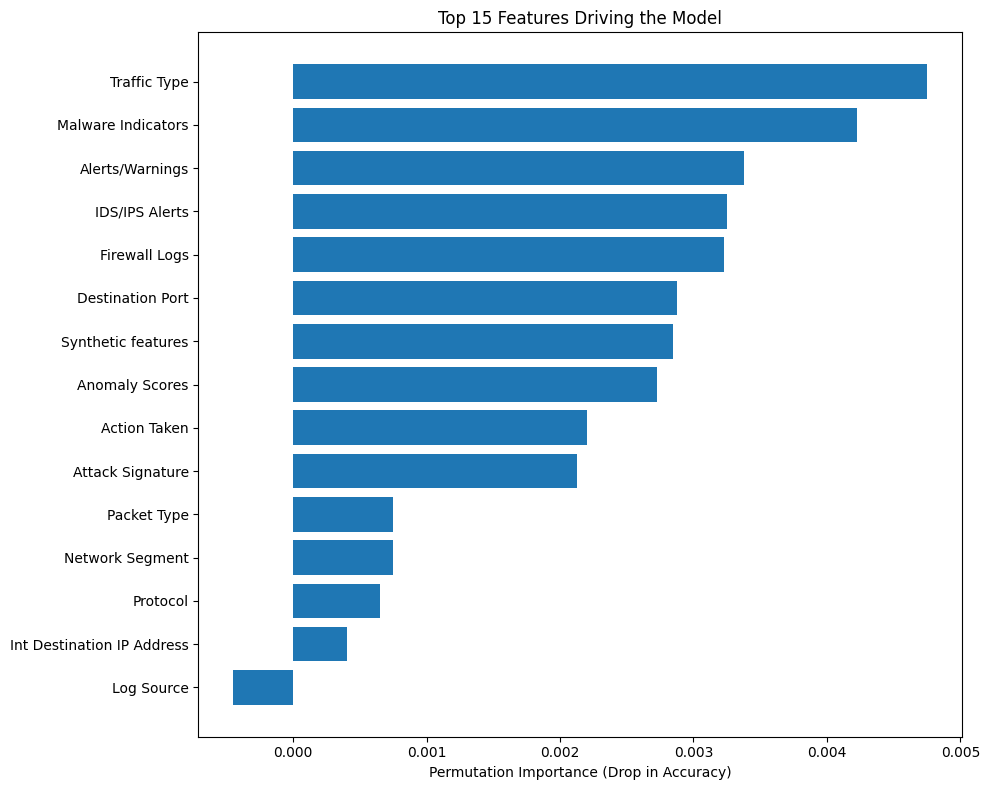

In [23]:
print("Calculating feature importance (Permutation Importance)...")
result = permutation_importance(pipeline, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[-15:] # Top 15 features
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Drop in Accuracy)")
plt.title("Top 15 Features Driving the Model")
plt.tight_layout()
plt.show()

Synthetic feature is not of importance contrary to what we could have expected

## Smote Tomek Approach

### Original Script

In [24]:
df = pd.read_csv(data_path.joinpath("cybersecurity_attacks.csv"))

X_orig = df.drop(columns=["Attack Type"])
y_true = df["Attack Type"].astype("category").cat.codes

num_cols = X_orig.select_dtypes(include=["int64","int32","float64"]).columns.tolist()
cat_cols = X_orig.select_dtypes(include=["object"]).columns.tolist()


/tmp/ipykernel_28611/3625923604.py:7: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.



In [ ]:
preproc_orig = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)
X_proc = preproc_orig.fit_transform(X_orig)

xgb_fs = XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=10,
        random_state=1312, tree_method="hist"
    )
xgb_fs.fit(X_proc, y_true)
importances_orig = xgb_fs.feature_importances_
idx_orig = np.argsort(importances_orig)[::-1][:min(800, X_proc.shape[1])]
X_sel = X_proc[:, idx_orig]
y_sel = y_true.copy()

if hasattr(X_sel, "toarray"):
    X_sel = X_sel.toarray()

sm = SMOTETomek(random_state=1312)
X_sel, y_sel = sm.fit_resample(X_sel, y_sel)
X_sel = PCA(n_components=0.98, svd_solver="full").fit_transform(X_sel)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_sel, y_sel, test_size=0.2, random_state=1312, stratify=y_sel
)

model = RandomForestClassifier(n_estimators=300, random_state=1312)
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
accuracy = accuracy_score(y_te, pred)
print(f"Final Accuracy: {accuracy:.4f}")
labels = ["DDoS", "Intrusion", "Malware"]
print(classification_report(y_te, pred, target_names=labels))

We can see an improvement compare to our baseline.
Unfortunately, there is data leakage at the XGBClassifier step because the whole dataset is used as input.
It means that the classifier is trained with the data from the test set hence the improvement.

## Proper pipeline for SMOTETOMEK approach

In [25]:
num_cols = X_orig.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_orig.select_dtypes(include=["object","str"]).columns.tolist()
_tmp = SimpleImputer(strategy="constant", fill_value="unknown").fit_transform(X_orig[cat_cols])
_tmp_ohe = OneHotEncoder(handle_unknown="ignore",drop="first").fit(_tmp)
all_categories = _tmp_ohe.categories_

# Custom transformer for XGBoost feature selection
class XGBFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=800, random_state=124):
        self.n_features = n_features
        self.random_state = random_state
        self.feature_indices_ = None
        
    def fit(self, X, y):
        # Train XGBoost to get feature importances
        xgb = XGBClassifier(
            n_estimators=200, 
            learning_rate=0.05, 
            max_depth=10,
            random_state=self.random_state, 
            tree_method="hist"
        )
        xgb.fit(X, y)
        
        # Select top N features
        importances = xgb.feature_importances_
        self.feature_indices_ = np.argsort(importances)[::-1][:min(self.n_features, X.shape[1])]
        return self
    
    def transform(self, X):
    
        return X[:, self.feature_indices_]
    
    def set_fit_request(self, *, y: bool = True):
        return self

cat_prepocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("enocder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True, categories=all_categories))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", cat_prepocessor, cat_cols),
    ]
)

clean_model = ImbPipeline([
    ("preprocessor", preprocessor),
    ('feature_selector', XGBFeatureSelector(random_state=RANDOM_STATE)),
    ("smote", SMOTETomek(random_state=RANDOM_STATE)),
    ("pca", PCA(n_components=200, svd_solver="auto")),
    ("classifier", RandomForestClassifier(**best_params, random_state=RANDOM_STATE))
])


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded)
clean_model.fit(X_train, y_train)
print("Model score: %.3f" % clean_model.score(X_test, y_test))
y_pred = clean_model.predict(X_test)
print(classification_report(y_pred, y_test, target_names=labels))

Model score: 0.323
              precision    recall  f1-score   support

        DDoS       0.31      0.33      0.32      2521
   Intrusion       0.33      0.32      0.32      2769
     Malware       0.33      0.32      0.33      2710

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.32      8000
weighted avg       0.32      0.32      0.32      8000



Back to 33%

### Search of Optimal Hyper-Parameters for SmoteTomek Approach

In [33]:

# Custom transformer for XGBoost feature selection
class XGBFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=800, random_state=124):
        self.n_features = n_features
        self.random_state = random_state
        self.feature_indices_ = None
        
    def fit(self, X, y):
        # Train XGBoost to get feature importances
        xgb = XGBClassifier(
            n_estimators=200, 
            learning_rate=0.05, 
            max_depth=10,
            random_state=self.random_state, 
            tree_method="hist"
        )
        xgb.fit(X, y)
        
        # Select top N features
        importances = xgb.feature_importances_
        self.feature_indices_ = np.argsort(importances)[::-1][:min(self.n_features, X.shape[1])]
        return self
    
    def transform(self, X):
    
        return X[:, self.feature_indices_]
    
    def set_fit_request(self, *, y: bool = True):
        return self


X_train, X_test, y_train, y_test = train_test_split(X_orig, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("feature_selector", XGBFeatureSelector(random_state=RANDOM_STATE)),
    ("smote", SMOTETomek(random_state=RANDOM_STATE)),
    ("pca", PCA(svd_solver="auto")),  # Use integer with auto solver
    ("classifier", RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    "feature_selector__n_features": [400, 800],
    "pca__n_components": [100, 200],
    "classifier__max_depth": [None, 10],
    "classifier__min_samples_split": [2, 5],
    "classifier__n_estimators": [100, 200]
}


In [ ]:
search = GridSearchCV(
    pipeline, 
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=3
)
search.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[CV 3/3] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100, feature_selector__n_features=400, pca__n_components=100;, score=0.320 total time= 2.1min
[CV 3/3] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100, feature_selector__n_features=400, pca__n_components=200;, score=0.337 total time= 2.3min
[CV 2/3] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100, feature_selector__n_features=800, pca__n_components=100;, score=0.341 total time= 2.4min
[CV 2/3] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100, feature_selector__n_features=400, pca__n_components=100;, score=0.334 total time= 2.4min
[CV 2/3] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100, feature_selector__n_features=400, pca__n_components=200;, score=0.334 total time= 2.5min
[CV 1/3] END classifier__max_depth=

NameError: name 'labels' is not defined

In [36]:

print("Best parameters found: ", search.best_params_)
pred = search.predict(X_test)

print(classification_report(y_test, pred, target_names=y_labels))

Best parameters found:  {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'feature_selector__n_features': 800, 'pca__n_components': 200}
              precision    recall  f1-score   support

        DDoS       0.31      0.20      0.24      2686
   Intrusion       0.33      0.51      0.40      2653
     Malware       0.31      0.25      0.28      2661

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.31      8000
weighted avg       0.32      0.32      0.31      8000

